In [363]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import sys
import re, string
import nltk, spacy, gensim
from scipy.stats.mstats import gmean
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, fbeta_score 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import FeatureUnion, Pipeline 

from numpy import dot
from numpy.linalg import norm
import pickle
import seaborn as sns

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from pprint import pprint
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
def load_data(data_splits):
    """
    Function that combines the DataFrame for training, validation, and test.
    """
    path = "dataset/archive/disaster_response_messages_{}.csv"
    dfs = []
    for data_split in data_splits:
        file_path = path.format(data_split)
        dfs.append(pd.read_csv(file_path))
    return pd.concat(dfs) #combine files for each split

In [4]:
def data_cleaning(data_df):
    """
    Function that cleans the data.
    """    
    data_df = data_df.drop_duplicates()
    return data_df 
    

In [5]:
def save_to_database(data_df,db_name):
    """
    Save data to database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Write dataframe to database
    data_df.to_sql('data_df',engine,if_exists='replace')
    pass 

In [6]:
def load_from_database(db_name):
    """
    Load data from database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Read dataframe from database
    data_df = pd.read_sql_table('data_df',engine)
    data_df = data_df.dropna(subset=["message"])
    X = data_df['message'].fillna(value='')
    C = data_df.iloc[:,4:]
    message_class = C.columns
    return X, C, message_class

In [82]:
def document_cleaning(data_df):
    """
    Function that cleans the document.
    """    

    data = data_df.values.tolist()                            # convert data to list
    data = [re.sub(r'\S*@\S*\s?', '', item) for item in data] # Remove email addresses
    data = [re.sub('[%s]' % re.escape(string.punctuation), ' ', item) for item in data] # Remove punctuations
    data = [re.sub(r'\s+', ' ', item) for item in data]       # Remove characters that begin a new line
    data = [re.sub(r"\'", "", item) for item in data]         # Remove single quotes
    data = [re.sub(r'\w*\d\w*', ' ', item) for item in data]  # Remove numbers
    data = [re.sub(r' +', ' ', item) for item in data]# Remove extra spaces
    data = [item.lower() for item in data]                    # Make each document lower case
    
    return data

In [8]:
def tokenize_doc(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [150]:
def similar_corpus(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    dist = euclidean_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    print(dist)
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [361]:
def similar_corpus_cosine(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    #dist = cosine_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    dist = cosine_similarity(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    print(dist)
    doc_ids = np.argsort(dist)[:top_n]
    print(np.argsort(dist))

    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [10]:
def model_pipeline():
    """
    Pipeline for model
    
    This ML pipeline remembers the complete set of preprocessing steps
    in the exact same order. On receipt of new data point, the ML pipeline
    performs the steps as defined and uses the model to make predictions.

    """

In [11]:
# Load Data

data_splits = ['training', 'validation', 'test']
disaster_df = load_data(data_splits)  
# Sort by 'column = id' and reset index
disaster_df.sort_values("id", ascending=True, inplace=True)
disaster_df.reset_index(drop=True, inplace=True)
# Drop the 'split' column
disaster_df = disaster_df.drop('split', axis=1)
disaster_df.shape

/var/folders/s4/7p7tgr117_b0jrzvzwbb4tym0000gn/T/ipykernel_49942/3510905850.py:4: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  disaster_df = load_data(data_splits)


(26248, 41)

In [12]:
# Data cleaning

disaster_df = data_cleaning(disaster_df)
disaster_df.shape

(26216, 41)

In [13]:
# Save data to SQLite Database

database_name = 'disaster_response.db'
save_to_database(disaster_df,database_name)

In [14]:
# Load data from database

X, C, message_class = load_from_database(database_name)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, C,test_size=.2, random_state=2018)

In [15]:
pprint(message_class)

Index(['genre', 'related', 'PII', 'request', 'offer', 'aid_related',
       'medical_help', 'medical_products', 'search_and_rescue', 'security',
       'military', 'child_alone', 'water', 'food', 'shelter', 'clothing',
       'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')


In [85]:
# Document cleaning

# X = X[:100]

message_data = document_cleaning(X)
pprint(message_data[:1])

['weather update a cold front from cuba that could pass over haiti']


In [17]:
# Tokenize documents
        
message_words = list(tokenize_doc(message_data))
print(message_words[:2])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over']]


In [18]:
# Stemming and Lammatization
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization for any choice to keep -  Noun, Adj, Verb, Adverb ['NOUN', 'ADJ', 'VERB', 'ADV']

message_lemmatized = lemmatization(message_words, allowed_postags=['NOUN', 'VERB'])
print(message_lemmatized[:1])

['weather update front pass']


In [19]:
# Document word Matrix
# minimum reqd occurences of a word # remove stop words # convert all words to lowercase # num chars > 3
# maximum number of unique features
vectorizer = CountVectorizer(analyzer='word',min_df=10,stop_words='english',lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',max_features=50000)
message_vectorized = vectorizer.fit_transform(message_lemmatized)

In [20]:
# LDA Model
# Number of topics # Max learning iterations # Random state # n docs in each learning iter
# compute perplexity every n iters, default: Don't, # Use all available CPUs

lda_model = LatentDirichletAllocation(n_components=20,max_iter=10,learning_method='online',   
                                      random_state=100, batch_size=128,evaluate_every = -1,n_jobs = -1)
lda_output = lda_model.fit_transform(message_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [21]:
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
                          n_components=10, n_jobs=-1,perp_tol=0.1,
                          random_state=100, topic_word_prior=None,total_samples=1000000.0, verbose=0)

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)

In [22]:
# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(message_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(message_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1582188.447823661
Perplexity:  1920.7602641614424
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [23]:
# GridSearch to find best parameters for LDA
params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=params)
# Do the Grid Search
model.fit(message_vectorized)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn', scoring=None, verbose=0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 25, 30]},
             return_train_score='warn')

In [24]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(message_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -330980.3673728643
Model Perplexity:  1384.0156598388623


In [44]:
# Dominant topics

# Create Document — Topic Matrix
lda_output = best_lda_model.transform(message_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(message_data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic
# Styling
def color_green(val):
 color = "green" if val > .1 else "black"
 return "color: {col}".format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return "font-weight: {weight}".format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.280000,0.030000,0.520000,0.030000,8
Doc1,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,8
Doc2,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,8
Doc3,0.010000,0.010000,0.250000,0.170000,0.010000,0.010000,0.010000,0.490000,0.010000,0.010000,7
Doc4,0.020000,0.020000,0.020000,0.020000,0.180000,0.180000,0.020000,0.020000,0.020000,0.520000,9
Doc5,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.700000,0.030000,8
Doc6,0.030000,0.030000,0.030000,0.030000,0.030000,0.700000,0.030000,0.030000,0.030000,0.030000,5
Doc7,0.020000,0.020000,0.640000,0.200000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,2
Doc8,0.020000,0.020000,0.020000,0.820000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,3
Doc9,0.010000,0.010000,0.870000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,2


In [26]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,abandon,ability,absence,absorb,abuse,accelerate,accept,access,accident,accommodate,...,yard,year,yesterday,yield,yorker,youth,yuan,zimbabwe,zinc,zone
Topic0,7.110928,0.111049,0.113194,0.104136,2.091383,17.144972,0.105306,0.112680,0.402277,0.104985,...,0.434346,0.119429,0.113021,26.440126,0.111914,0.106664,0.128297,27.421169,0.105028,0.107837
Topic1,0.107461,0.106477,0.105775,0.103557,0.105802,0.106069,0.111551,40.211977,12.516382,0.138914,...,0.106066,946.979876,0.105901,0.109117,0.105492,0.104769,0.141783,0.104555,0.105585,0.124221
Topic2,0.106764,0.105228,0.105200,0.105649,0.106040,0.104449,0.104269,131.733704,0.105553,0.112917,...,0.119188,0.110530,0.112782,0.112782,0.107529,0.786894,0.107832,0.105362,0.111577,165.654288
Topic3,0.116915,0.119971,0.118321,0.104700,0.105382,0.105158,0.173975,0.458260,0.104660,0.107121,...,17.288915,33.277357,78.067711,0.103869,0.103722,0.133818,0.107711,0.120129,3.064380,0.237240
Topic4,0.108310,0.128934,0.161757,0.105612,0.105240,0.104526,0.105028,0.108407,24.264220,0.106684,...,0.135559,0.513474,0.108403,2.443523,0.104682,0.106031,0.167452,2.762943,0.113668,11.681904


In [50]:
# Keyword-topic Matrix for top n words

keyword_topic_df = pd.DataFrame(best_lda_model.components_).T
# Assign Column and Index
keyword_topic_df.index = vectorizer.get_feature_names()
keyword_topic_df.columns = topicnames
# View
keyword_topic_df.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
abandon,7.110928,0.107461,0.106764,0.116915,0.108310,0.112610,0.105627,0.104990,0.104800,23.603280
ability,0.111049,0.106477,0.105228,0.119971,0.128934,0.133046,0.139116,37.120588,0.107083,0.526052
absence,0.113194,0.105775,0.105200,0.118321,0.161757,0.105333,0.104852,0.104220,0.106009,20.063668
absorb,0.104136,0.103557,0.105649,0.104700,0.105612,11.776154,0.104860,0.104731,0.104613,0.105340
abuse,2.091383,0.105802,0.106040,0.105382,0.105240,0.107128,0.107232,28.791981,0.106043,0.107473


In [36]:
# Show top n keywords for each topic

def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

#Keyword-topic
df_keywords_topic = pd.DataFrame(topic_keywords).T
df_keywords_topic.columns = ['Topic '+str(i) for i in range(df_keywords_topic.shape[1])]
df_keywords_topic.index = ['Word '+str(i) for i in range(df_keywords_topic.shape[0])]

df_keywords_topic

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Word 0,flood,say,water,help,earthquake,disease,include,day,information,country
Word 1,come,year,food,people,rain,storm,home,report,team,say
Word 2,use,make,need,house,affect,city,camp,shelter,hurricane,continue
Word 3,area,http,people,need,region,river,project,child,disaster,emergency
Word 4,number,school,aid,thank,damage,operation,result,support,weather,province
Word 5,start,cause,help,know,road,population,government,service,land,follow
Word 6,crop,relief,tent,work,area,flooding,risk,hospital,community,leave
Word 7,suffer,state,family,message,hit,case,know,woman,base,situation
Word 8,wind,effort,area,send,time,today,think,world,development,port
Word 9,set,quake,village,destroy,level,lead,like,health,night,government


In [47]:
# Message-Topic-Matrix
df_document_topic['message'] = message_data
df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,message
Doc0,0.03,0.03,0.03,0.03,0.03,0.03,0.28,0.03,0.52,0.03,8,weather update a cold front from cuba that cou...
Doc1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,8,is the hurricane over or is it not over
Doc2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,8,looking for someone but no name
Doc3,0.01,0.01,0.25,0.17,0.01,0.01,0.01,0.49,0.01,0.01,7,un reports leogane destroyed only hospital...
Doc4,0.02,0.02,0.02,0.02,0.18,0.18,0.02,0.02,0.02,0.52,9,says west side of haiti rest of the country to...
...,...,...,...,...,...,...,...,...,...,...,...,...
Doc26211,0.28,0.01,0.01,0.01,0.09,0.11,0.01,0.01,0.36,0.12,8,the training demonstrated how to enhance micro...
Doc26212,0.35,0.01,0.01,0.17,0.01,0.01,0.01,0.01,0.38,0.01,8,a suitable candidate has been selected and och...
Doc26213,0.18,0.02,0.18,0.18,0.02,0.02,0.02,0.02,0.18,0.18,0,proshika operating in cox s bazar municipality...
Doc26214,0.34,0.01,0.01,0.11,0.01,0.10,0.10,0.11,0.10,0.11,0,some women protesting against the conduct ...


## Topic interpretation

* ### Topic0

In [55]:
# Topic interpretation
# interpreted as: INFORMATION_RELATED


tmp_df = df_document_topic.sort_values('Topic0', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()


please i am suffering give me a cahnce to save a life please call this number so i can be involved thak you four comprehension

we lack good quality seed and termites eat our plants 

the frankenstorm is coming the frankenstorm is coming it s alive hurricanesandy sandy

what is the exchange rate between the gourdes and the dollars 

jenga and wine by fake candle light f u sandy inn http t co   and light winds on w   nothing yet sandy

i will come to pick you up at   o clock i am all yours my darling 

unrecognized characterse initial formation accelerated organized by menfp financed by bid launched in truncated

the cyber cafes are not all damaged at clercine but their owners left for the countryside because of lack of security

what is the exchange rate for the us dollar 

the third fight i had to diffuse in a span of   c mon people quit actin like savages sandy



* ### Topic1

In [58]:
# Topic interpretation
# interpreted as: NEWS UPDATE

tmp_df = df_document_topic.sort_values('Topic1', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

 british airways charitable partner comic relief has already donated over ¬¨¬£  to the relief effort 

rescuers altogether found three corpses from the landslide debris with wenshan county by   p m on saturday 

one hundred percent of your gift goes to relief and recovery efforts 

hard because everything is sold sky high small rice tin can is sold for     a roughly     us

as of this year radical groups now controlled more moderate opposition elements 

their top leaders are being detained in jails after the mass uprising in august last year 

we are members of the organisation ochanh we see that people are complaining that they are hungry the government must do something now 

the state government has opened relief centres at the mirwaiz manzil and jamia masjid 

the geologist said that there will be no more aftershocks after february   therefore schools can reopen 

whatus menjs national education says in the exam affairs neither this year 



* ### Topic2

In [59]:
# Topic interpretation
# interpreted as: AID_RELATED - FOOD,WATER,SHELTER,MEDICINE

tmp_df = df_document_topic.sort_values('Topic2', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

please when you distribute the cards that give access to aid don t give them to just anyone at delma   we have to buy those cards for   cents delma   has too much chaos for cards to be distributed 

the people from cite castro in mais gate   we need aid such as food water tents and much more we are about   people in the area the area is the airport area 

please tell the ngo that it is not important which water bottle the medicine we treated water with aquatab is what we need because we have water martissan 

address carrefour r street saint louis weneed food tents waters sleeping bags or sleeping mats please help thank you

unhcr is also distributing tents plastic sheets sleeping mats and hygiene and sanitation items in unflooded areas of leitchuor and nip nip 

we haven t received anything in terms of aid for example we nee food medicine doctors and tents to sleep in to be okay in sid 

i live brace leandre in area of leogane we don t have water treat for drinking when we are drinkin

* ### Topic3

In [61]:
# Topic interpretation
# interpreted as: INFRASTRUCTURE_RELATED / JOB_REQUEST

tmp_df = df_document_topic.sort_values('Topic3', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

below the house ok thank you for all the texts you sent for me and are sending for me still thank you thank you than you it is you who are there with me thank you don t give up on me ok thank you

digicell it s a good thing this is a personal question my house is fallen i need help the money we give the government doesn t fix anything we know that well

i do not want to become a delinquent i want to work because i believe in it i want everything that i ll have i receive it by my work i wait for your answer 

we need all kinds of help in bon repos route ona vile the people really need help 

i wrote before you didn t answer me we are located at carrefour maren there s a lot of death victims we need help

hello i am pregnant my house has been destroyed i am living in the street myself my husband and our   kids there is one month until i give birth i am asking what we can 

our mother doesnt work and the children are small i ask please help mother work in miami so she can help us not die 

* ### Topic4

In [62]:
# Topic interpretation
# interpreted as: SEVERE WEATHER UPDATE

tmp_df = df_document_topic.sort_values('Topic4', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

a cold front was discovered over cuba this morning it could cross haiti tomorrow isolated rain showers are predicted for our region tonight 

a cold front is upon cuba this morning it may hit haiti tomorrow isolated rain showers are expected for our region tonight 

a cold front hit cuba this morning it could affect haiti tomorrow isolated showers are again expected in our region tonight 

a cold front is found over cuba this morning it could cross haiti tomorrow isolated rain showers are expected over our region tonight 

a cold front is on cuba this morning it could cross haiti tomorrow isolated rain showers are expected for our region 

a cold front is over cuba this morning it could cross haiti tomorrow isolated rain showers are still forcasted over our region tonight 

a cold front has hit cuba this morning it could move into haiti isolated rain showers are still forecasted for our region this evening 

the latest deaths took a nationwide death toll linked to the annual monsoon ra

* ### Topic5

In [63]:
# Topic interpretation
# interpreted as: OPINION/OTHER_REQUESTS

tmp_df = df_document_topic.sort_values('Topic5', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

taking our case into consideration movement of peasants cane from deslands please advise

ndski hey everything ok here at santiago classes delayed one week wanna go to the gym and wanna rave hahaha what bout you 

i reiterate that the proper and full implementation of the prohibition of incitement to hatred as per human rights treaties would be a better alternative to blasphemy laws 

an active surveillance for communicable diseases at inpatient wards has been established 

back into the jungle floor is shaking right now kinda getting familiar with plate tectonic movements back in santiago 

     doses of measles vaccines and syringes     doses of yellow fever vaccines and syringes     doses of cerebrospinal meningitis vaccines and syringes and     doses of polio vaccines unicef

the scale and intensity of deforestation soil erosion and declines in soil productivity are enormous 

 wow this storm was sooooo crazy hasn t even begun 

my soul cries to lord my soul cries for my freedom of

* ### Topic6

In [64]:
# Topic interpretation
# interpreted as: EARTHQUAKE UPDATE

tmp_df = df_document_topic.sort_values('Topic6', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

acabo de leer paper interseismic strain accumulation measured by gps in the seismic gap between constituci‚àö‚â•n and concepci‚àö‚â•n in chile uf 

interseismic strain accumulation measured by gps in the seismic gap between constitucion and concepcion in chile 

interseismic strain accumulation measured by gps in the seismic gap between constituci‚àö‚â•n and concepci‚àö‚â•n in chile eso 

interseismic strain accumulation measured by gps in the seismic gap nbetween constituci‚àö‚â•n and concepci‚àö‚â•n in chile estaba clarito desde  

anyta interseismic strain accumulation measured by gps in the seismic gap between constituci‚àö‚â•n and concepci‚àö‚â•n in chile

ernandopaulsen citation interseismic strain accumulation measured by gps in the seismic gap between constitucion and concepcion in chile

la probabilidad advertida interseismic strain accumulation measured by gps in the seismic gap between constituci‚àö‚â•n and concepci‚àö‚â•n in chile

atiasdelrio interseismic strain accumulati

* ### Topic7

In [65]:
# Topic interpretation
# interpreted as: CLOTHING/MEDICAL_PRODUCTS

tmp_df = df_document_topic.sort_values('Topic7', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

here is a list of the items we have to offer men s women s coats and winter wear children s coats and winter wear boys girls children s and baby toys and stuffed animals all new w tags blankets all new w tags toiletries hygiene products water cleaning supplies

hygienic mobile toilets batteries generators dlo toiletries clothes linens underwear   women   men

the doctors without borders hospital in delmas   is closed the saint louis gonzaga hospital in delmas   is taken in sick and wounded people for free 

i have a license in computer science i need employment i live at tabarre  

can you contact a post radio station for us because w do not have any representatives for any assistance in f v r t 

refugees from afghanistan arriving in pakistan in recent days report that the taliban are forcibly conscripting young men and boys 

i have a box of   diapers   wipes some canned foods body wash shampoo rinse

we are in need of assistance we are abandonned here in petionville between dirgue r

* ### Topic8

In [66]:
# Topic interpretation
# interpreted as: TRANSPORT/TRAVEL INFORMATION

tmp_df = df_document_topic.sort_values('Topic8', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

belgium offered two c   transport planes and two helicopters to back up france s offensive while britain and canada have offered troop transporters 

my awesome sign weather sandy hurricane doom nyc bakery apocolypse stockupo bakery http t co   gov christie is about to address for jersey about the hurricane 

to register your name or someone your looking for go to www cicr org

i would like more information on the trip to santo domingo

please i would like to register so i can receive all the information 

i would like to get some information about getting a visa for us to go to senegal please 

hello i would like more information about immigration to senegal please 

seeking information on getting a visa to go to senegal 

information on land tremors instability 

i would like some more informations about travelling to senegal 



* ### Topic9

In [67]:
# Topic interpretation
# interpreted as: SECURITY/HEALTH/ENVIRONMENT CONCERNS

tmp_df = df_document_topic.sort_values('Topic9', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

 there are real security threats in mali but brutalizing detainees and civilians is not the way to address them dufka said 

what said the ministry finance and the ministry trade on the ratement of gasoline in the country 

can people from the provinces go into port au prince without problems 

what are you doing with the provinces you managed to do the decentralization in the wrong way without infrastructure in misery how are you going to keep thiese peopl we already counterd   without 

these people that are in providence may be a banned we are hungry they have problems of health and institution 

samples taken from around the country showed that sewage from rawalpindi lahore multan karachi hyderabad sukkur quetta and jacobabad still contained traces of the poliovirus 

are the people who left to the country side will not be able to return 

the solution to the current political deadlock on climate change was very simple he continued 

how can the government deliver a birth certifica

In [69]:
# Put inferred topics into dataframe

Topics = ["AID/INFORMATION RELATED","NEWS UPDATE","AID_RELATED - FOOD,WATER,SHELTER,MEDICINE",\
           "INFRASTRUCTURE_RELATED / JOB_REQUEST","SEVERE WEATHER UPDATE","OPINION/OTHER_REQUESTS",\
           "EARTHQUAKE UPDATE","CLOTHING/MEDICAL_PRODUCTS","TRANSPORT/TRAVEL INFORMATION",\
           "SECURITY/HEALTH/ENVIRONMENT CONCERNS"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,flood,come,use,area,number,start,crop,suffer,wind,set,life,eat,victim,add,crisis,AID/INFORMATION RELATED
Topic 1,say,year,make,http,school,cause,relief,state,effort,quake,work,tsunami,response,bit,people,NEWS UPDATE
Topic 2,water,food,need,people,aid,help,tent,family,area,village,supply,power,district,live,distribute,"AID_RELATED - FOOD,WATER,SHELTER,MEDICINE"
Topic 3,help,people,house,need,thank,know,work,message,send,destroy,want,job,like,ask,note,INFRASTRUCTURE_RELATED / JOB_REQUEST
Topic 4,earthquake,rain,affect,region,damage,road,area,hit,time,level,month,week,expect,rainfall,morning,SEVERE WEATHER UPDATE
Topic 5,disease,storm,city,river,operation,population,flooding,case,today,lead,season,farmer,resident,attack,cyclone,OPINION/OTHER_REQUESTS
Topic 6,include,home,camp,project,result,government,risk,know,think,like,condition,prevent,news,measure,collapse,EARTHQUAKE UPDATE
Topic 7,day,report,shelter,child,support,service,hospital,woman,world,health,winter,use,supply,need,programme,CLOTHING/MEDICAL_PRODUCTS
Topic 8,information,team,hurricane,disaster,weather,land,community,base,development,night,survivor,building,concern,pass,transport,TRANSPORT/TRAVEL INFORMATION
Topic 9,country,say,continue,emergency,province,follow,leave,situation,port,government,fund,people,health,plan,temperature,SECURITY/HEALTH/ENVIRONMENT CONCERNS


In [128]:
# make Prediction using LDA

# Define function to predict topic for a given text document.
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def topic_prediction(text, nlp=nlp):
    global tokenize_doc
    global lemmatization
# Step 1: Clean with simple_preprocess
    text_doc2 = list(tokenize_doc(text))
# Step 2: Lemmatize
    text_doc3 = lemmatization(text_doc2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    text_doc4 = vectorizer.transform(text_doc3)
# Step 4: LDA Transform - Save these two files as models. 
    topic_probability_scores = best_lda_model.transform(text_doc4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
# Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
#topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores

# Predict the topic
text_doc = ["Can we get some food"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
print(topic)
print(infer_topic)

['food', 'need', 'people', 'aid', 'help', 'tent', 'family', 'area', 'village', 'supply', 'power', 'district', 'live']
AID_RELATED - FOOD,WATER,SHELTER,MEDICINE


### Cluster documents that share similar topics

In [257]:
# Apply clustering on document-topic probability matrix
# kMeans , k = 10, Number of topics
k = 10
kmeans       = KMeans(n_clusters=k, random_state=100)
kmeans_clust = kmeans.fit_predict(lda_output)

In [258]:
# Build SVD model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_svd = svd_model.fit_transform(lda_output)

In [259]:
# plot axes using SVD decomposition
x_val = lda_svd[:, 0]
y_val = lda_svd[:, 1]

In [260]:
print("Weights of Component's: \n", np.round(svd_model.components_, 3))
print("Percentage of Variance Explained by X and Y Components: \n", np.round(svd_model.explained_variance_ratio_, 3))

Weights of Component's: 
 [[ 0.237  0.269  0.455  0.56   0.291  0.25   0.19   0.264  0.209  0.234]
 [-0.107 -0.105 -0.514  0.799 -0.122 -0.138 -0.074 -0.13  -0.067 -0.12 ]]
Percentage of Variance Explained by X and Y Components: 
 [0.025 0.237]


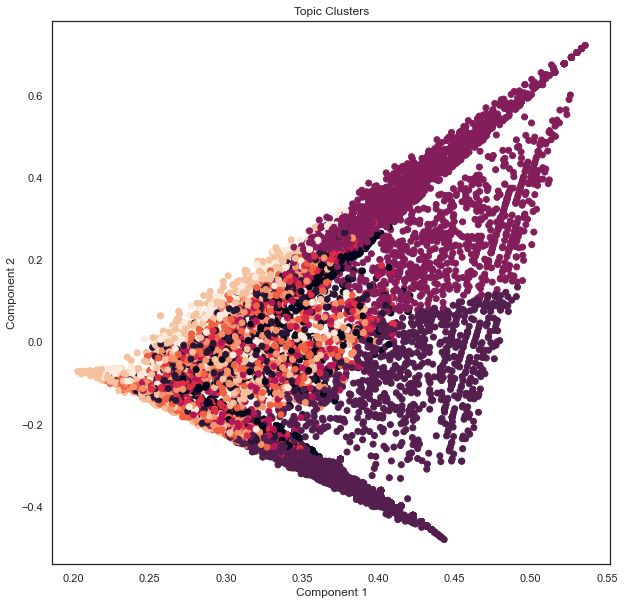

In [261]:
# Plot the cluster of points by topics

plt.figure(figsize=(10, 10))
plt.scatter(x_val, y_val, c=kmeans_clust)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters");
#plt.legend()

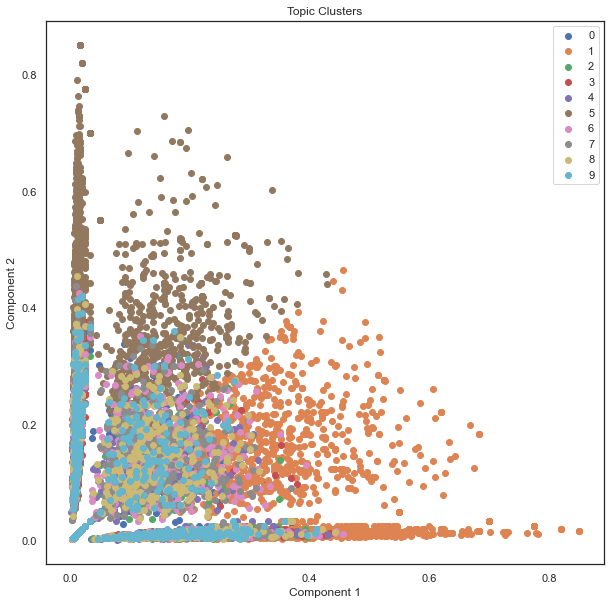

In [288]:
# Plot the cluster of points by topics

k_clusters = np.unique(kmeans_clust)
plt.figure(figsize=(10, 10))
for i in k_clusters:
    filtered_label = lda_output[kmeans_clust == i]
    plt.scatter(filtered_label[:,0], filtered_label[:,1], label = i)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")
plt.legend();

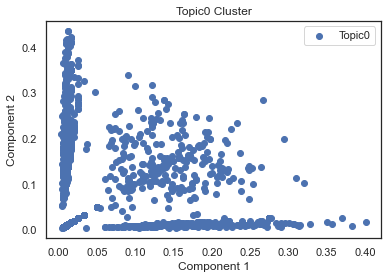

In [286]:
# Topic0 Cluster

filtered_label0 = lda_output[kmeans_clust == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], label = "Topic0")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic0 Cluster")
plt.legend();

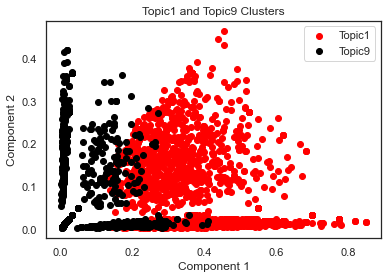

In [285]:
# Topic0 and Topic 1 Clusters
filtered_label1 = lda_output[kmeans_clust == 1]
 
filtered_label9 = lda_output[kmeans_clust == 9]
 
#Plotting the results
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'red', label = "Topic1")
plt.scatter(filtered_label9[:,0] , filtered_label9[:,1] , color = 'black', label = "Topic9")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic1 and Topic9 Clusters")
plt.legend();

### Find documents within a topic that are similar to a given document

In [165]:
# Using Euclidean distance

text_example = ["We need food and medical suppies. The kids also need blankets and clothing"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
print(topic)
print(infer_topic)
doc_ids, docs = similar_corpus(text=text_example, doc_topic_probs=lda_output, documents = message_data, top_n=1, verbose=False)
print('\n', docs[0][:500])
print()

['food', 'need', 'people', 'aid', 'help', 'tent', 'family', 'area', 'village', 'supply', 'power', 'district', 'live']
AID_RELATED - FOOD,WATER,SHELTER,MEDICINE
[0.89168311 0.84944559 0.84944469 ... 0.58208321 0.78070781 0.87485221]

 we live in la pleine since tuesday we ve been sleeping on the street hunger is killing us 



In [360]:
# Using cosine similarity

text_example = ["We need food and medical suppies. The kids also need blankets and clothing"]
doc_ids, docs = similar_corpus_cosine(text=text_example, doc_topic_probs=lda_output, documents = message_data, top_n=1, verbose=False)
print('\n', docs[0][:500])
print()

[0.91621504 0.85975857 0.85975824 ... 0.4196884  0.86426126 0.94347798]
[ 6690   122  1057 ... 11245  2834 10543]

 we would like for the water company to intervene at fontamara and rue jannot prolongee extension 



In [173]:
# Plot distributions
tmp_words = []
for i in range(len(message_words)):
    tmp_words.append(len(message_words[i]))

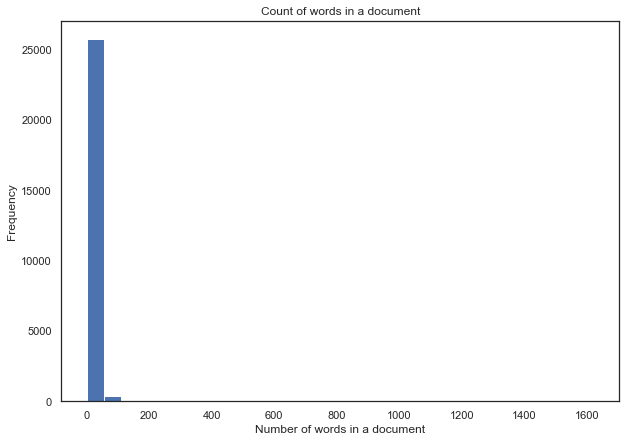

In [187]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
ax.hist(tmp_words,30);
ax.set_title('Count of words in a document')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of words in a document');

In [246]:
# Plots number of documents in topic

topic_list = []
topic_count = []
tot_topic = len(Topics)
for i in range(tot_topic):
    topic_l = Topics[i]
    mask = df_document_topic['dominant_topic'] == i
    topic_c = len(df_document_topic[mask])
    topic_list.append(topic_l)
    topic_count.append(topic_c)

topic_count_dict = {'Topic': topic_list, 'Count': topic_count}
topic_count_df = pd.DataFrame(topic_count_dict)
topic_count_df2 = topic_count_df.sort_values('Count', ascending = False)

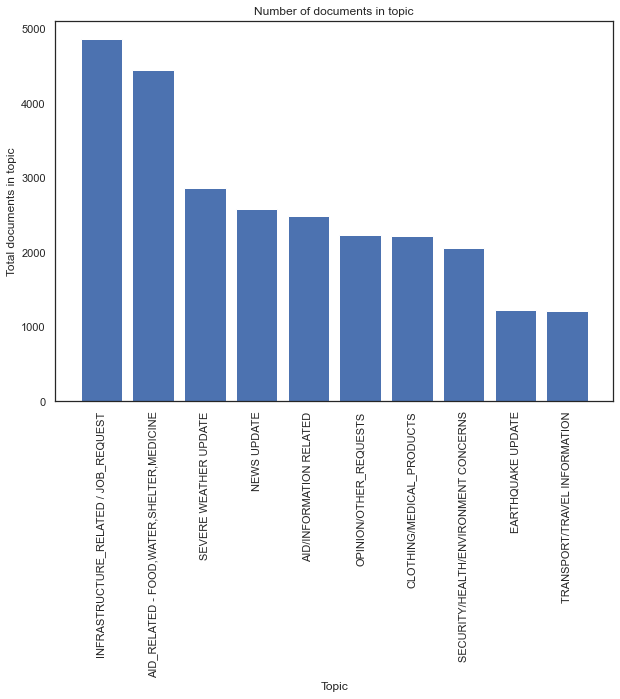

In [252]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
x_index = np.arange(topic_count_df2.Topic.count())
ax.set_xticks(ticks=x_index)

ax.bar(x_index,topic_count_df2['Count']);
ax.set_title('Number of documents in topic')
ax.set_ylabel('Total documents in topic')
ax.set_xlabel('Topic');
ax.set_xticklabels(topic_count_df2['Topic'],rotation = 90, horizontalalignment = 'center' );

### Frequency of keywords in topic

In [304]:
def flatten(outer_list):
    '''
    Function to flatten a list of list
    '''
    return [item for sublist in outer_list for item in sublist]

In [337]:
# top keywords count for Topic 0

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = df_document_topic['dominant_topic'] == 0
topic_kw_df =df_document_topic[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in df_keywords_topic['Topic 0']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

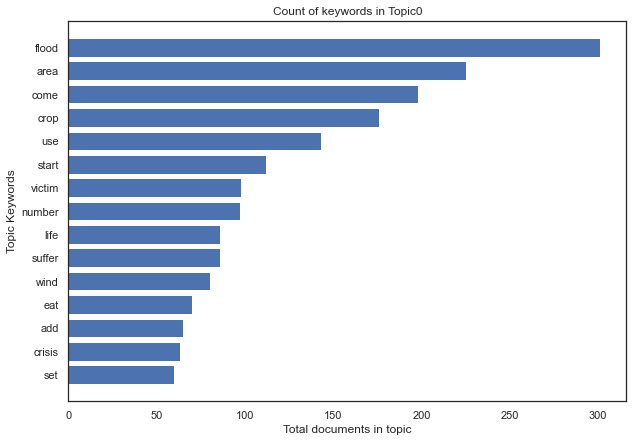

In [349]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic0')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [350]:
# top keywords count for Topic 4

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = df_document_topic['dominant_topic'] == 4
topic_kw_df =df_document_topic[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in df_keywords_topic['Topic 4']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

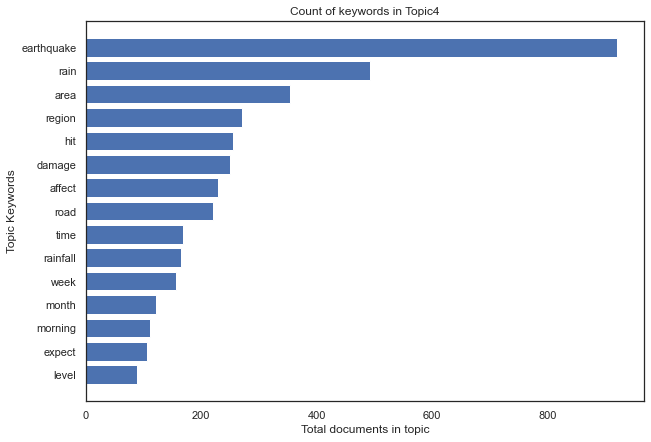

In [351]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic4')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [352]:
# top keywords count for Topic 9

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = df_document_topic['dominant_topic'] == 9
topic_kw_df =df_document_topic[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in df_keywords_topic['Topic 9']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

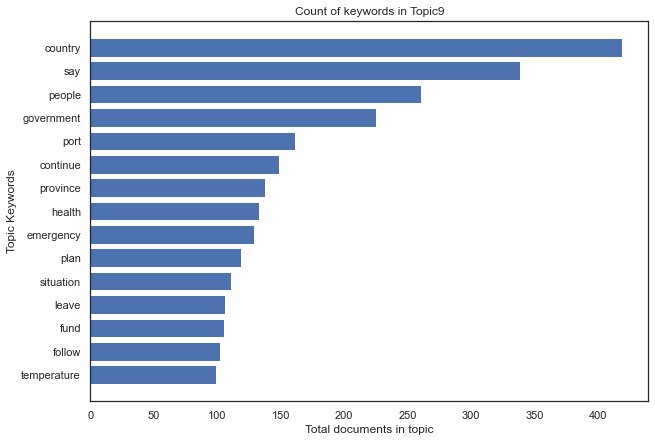

In [353]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic9')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');